In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
import matplotlib.cm as cm
import plotly.express as px
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.cluster import KMeans, BisectingKMeans, AgglomerativeClustering
from sklearn.base import clone
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split
from scipy.spatial import ConvexHull
from matplotlib.lines import Line2D

In [2]:
warnings.simplefilter(action='ignore')
plt.rc("font", size=14)
sns.set(style="white") #white background style for seaborn plots
sns.set(style="whitegrid", color_codes=True)

## Chargement des données du catalogue avec CO2

In [3]:
catalogue = pd.read_csv("data/Catalogue_cleaned_local.csv", encoding='utf8')

In [6]:
data_clustering = catalogue.copy()

## Entrainement du modèle de clustering

In [7]:
def reduce_to_2d_and_show(X,show=True,get_reduces=False):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    ts = TSNE(n_components=2)
    X_ts = ts.fit_transform(X)
    if show:
        fig, (ax1, ax2) = plt.subplots(1,2)
        ax1.scatter(X_pca[:,0],X_pca[:,1])
        ax1.set_title("Avec PCA")
        ax2.scatter(X_ts[:,0],X_ts[:,1])
        ax2.set_title("Avec TSNE")
        plt.suptitle("Nuage de points",fontweight="bold")
        plt.show()
    if get_reduces:
        return X_pca, X_ts

def c_silhouette_score(estimator, X):
    clusters = estimator.fit_predict(X)
    score = metrics.silhouette_score(X, clusters)
    return score

def centeroidnp(arr):
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    return sum_x/length, sum_y/length

def get_center_clusters(n_clusters, cluster_labels, X):
    center_clusters = []
    for i in range(n_clusters):
        points = X[cluster_labels == i]        
        x_mean = np.mean(points[:,0])
        y_mean = np.mean(points[:,1])
        c = centeroidnp(points)
        center_clusters.append(np.array(c))
    return np.array(center_clusters)

def show_inertie(data):
    min_clusters = 2
    max_clusters = 7
    inertie = []
    for k in range(min_clusters, max_clusters):
        kmeans = KMeans(n_clusters=k).fit(data)
        inertie.append(kmeans.inertia_)
    max_intertie = int(max(inertie))
    plt.figure(figsize=(10, 7))
    plt.plot(range(min_clusters, max_clusters), inertie, marker='+');
    plt.xlabel('Nombre de cluster')
    plt.ylabel('Inertie')
    plt.xticks(range(min_clusters,max_clusters))
    plt.show()

## Préparation des données

Suit a l'analyse exploratoire des données, les features sélectionnées pour l'entrainement sont les suivantes :

- longueur
- prix
- nbPortes
- nbPlaces

Le pré-traitenement des données consiste a appliqué les transformations suivantes :

- OneHotEncoder
    - longueur
- Binarizer
    - nbPlaces
    - nbPortes
- StandardScaler
    - prix

In [85]:
X = catalogue.copy()

In [109]:
onehot_encoder = preprocessing.OneHotEncoder(handle_unknown="ignore")
scaler = preprocessing.StandardScaler()
binarizer = preprocessing.Binarizer()

La pipeline de transformation ce présente comme suite.

In [110]:
onehot_features = ["longueur"]
scaler_features = ["prix"]
binarizer_features = ["nbPortes","nbPlaces"]

onehot_encoder_transformer = Pipeline(steps=[
    ('onehot_encoder', onehot_encoder)
])

binarizer_transformer = Pipeline(steps=[
    ('binarizer', binarizer)
])

numeric_transformer = Pipeline(steps=[
    ('scaler', scaler)
])

transformers = ColumnTransformer(
   transformers=[
    ('onehot_transform', onehot_encoder_transformer, onehot_features),
    ('binarize_transform', binarizer_transformer, binarizer_features),
    ('numeric_transform',numeric_transformer, numeric_features)
])

pipeline = Pipeline([
    ('transform', transformers)
])

In [111]:
pipeline.fit(X)

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('onehot_transform',
                                                  Pipeline(steps=[('onehot_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['longueur']),
                                                 ('binarize_transform',
                                                  Pipeline(steps=[('binarizer',
                                                                   Binarizer())]),
                                                  ['nbPortes', 'nbPlaces']),
                                                 ('numeric_transform',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['prix'])]))])

In [112]:
X_train = pipeline.transform(X)

Après transformation des données et reduction des dimensions avec avec PCA et TSNE l'ensemble des samples ce represente comme suite.

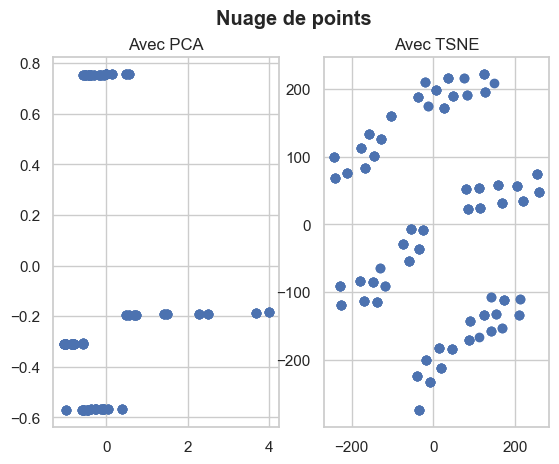

In [114]:
reduce_to_2d_and_show(X_train)

Le clustering consistera donc a grouper les points de sorte à regrouper les points ayant le plus de similitures (Penser à faire dentogramme).

Penser à présenter la méthode qui a permet de choisir que notre k = 4.

Penser à lister les algorithmes de clustering, la metrique de comparaison, les graphiques pour les comparer entre-eux et dire qu'on a choisi k-means. (Ne pas oublié qu'on a une grille de validation et précisez les paramètres)

## Entrainement

Le modele choisi est Kmeas avec k = 4 (Precisez ses parametres)

In [116]:
n_clusters = 4

param_grid = {
    "n_clusters":[n_clusters],
    "random_state": range(11),
    "init":["random"],
    "n_init": range(2,10)
}

kmeans = KMeans()

grid = GridSearchCV(kmeans,param_grid=param_grid,cv=5,verbose=1)
grid.fit(X_train)
    
print("\nRésultats:\n")
print(f"Configuration: \t",grid.best_estimator_)
print(f"Score: \t\t",grid.best_score_)
print(f"Paramètres: \t",grid.best_params_)

Fitting 5 folds for each of 88 candidates, totalling 440 fits

Résultats:

Configuration: 	 KMeans(init='random', n_clusters=4, n_init=3, random_state=1)
Score: 		 -18.64885851201608
Paramètres: 	 {'init': 'random', 'n_clusters': 4, 'n_init': 3, 'random_state': 1}


## Visualisation des clusters

Affichage du clustering obtenu

kmean-4 silhouette_score: 0.6602465980991867
Taux de points mal classé: 0%



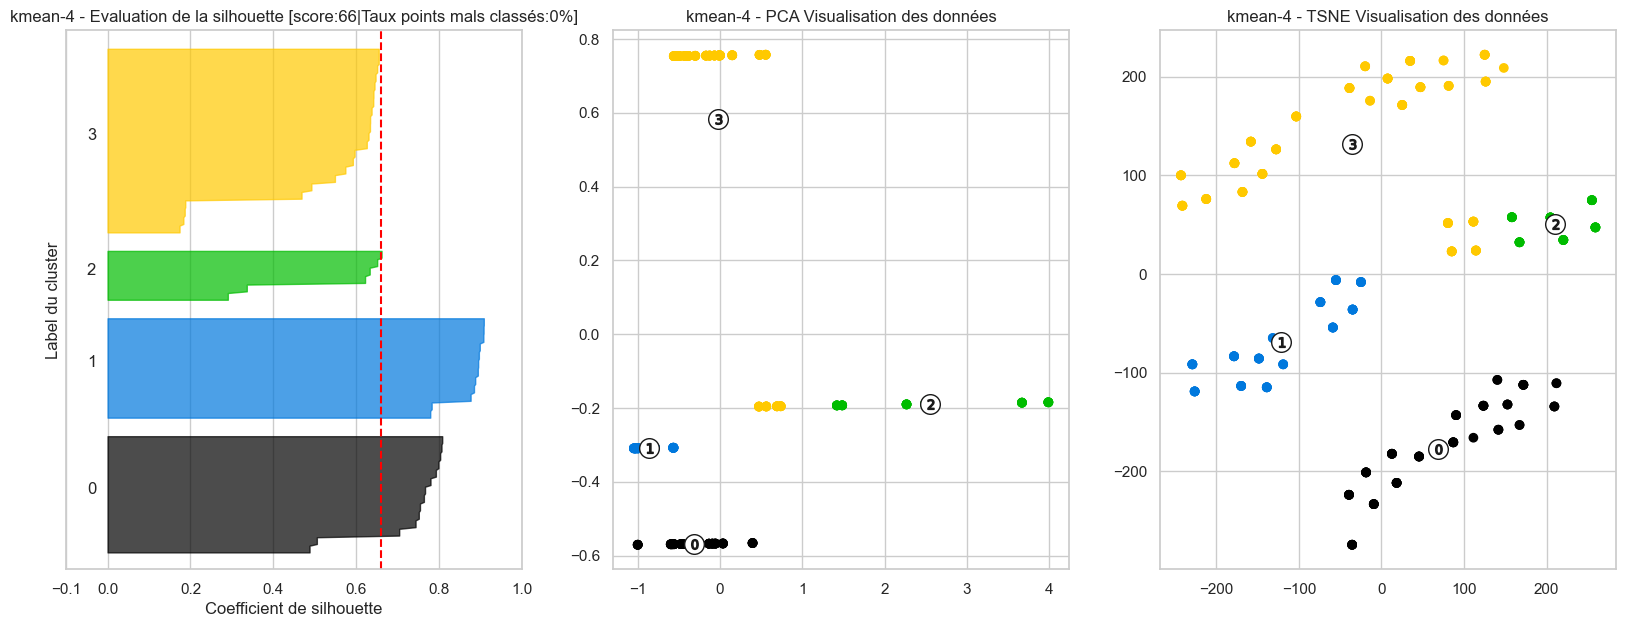

In [115]:
# Réduction des dimensions
pca = PCA(n_components=2)
ts = TSNE(n_components=2)
X_pca = pca.fit_transform(X_train)
X_ts = ts.fit_transform(X_train)
    
estimator = grid.best_estimator_
config_name = f"kmean-{n_clusters}"
    
silhouette_score = metrics.silhouette_score(X_train, estimator.labels_, metric='euclidean')
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(20, 7)
    
ax1.set_xlim([-0.1, 1])
ax1.set_ylim([0, len(X_train) + (n_clusters + 1) * 10])
    
cluster_labels = estimator.labels_
sample_silhouette_values =  metrics.silhouette_samples(X_train, cluster_labels)
nb_bad_sample = (sample_silhouette_values <= 0).sum()
silhouette_score_ratio = int(silhouette_score * 100)
bad_sample_ratio = int((nb_bad_sample / sample_silhouette_values.shape[0]) * 100)
    
print(f"{config_name} silhouette_score: {silhouette_score}")
print(f"Taux de points mal classé: {bad_sample_ratio}%")
print()

y_lower = 10
    
for i in range(n_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    color = cm.nipy_spectral(float(i) / n_clusters)
    
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )
    
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10
    
ax1.set_title(f"{config_name} - Evaluation de la silhouette [score:{silhouette_score_ratio}|Taux points mals classés:{bad_sample_ratio}%]")
ax1.set_xlabel("Coefficient de silhouette")
ax1.set_ylabel("Label du cluster")
ax1.axvline(x=silhouette_score, color="red", linestyle="--")
ax1.set_yticks([])
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)      
center_clusters_pca = get_center_clusters(n_clusters, cluster_labels, X_pca)
center_clusters_ts = get_center_clusters(n_clusters, cluster_labels, X_ts)

# PCA
ax2.scatter(X_pca[:, 0], X_pca[:, 1], c=colors)
ax2.scatter(center_clusters_pca[:, 0],center_clusters_pca[:, 1],marker="o",c="white",alpha=1,s=200,edgecolor="k")
ax2.set_title(f"{config_name} - PCA Visualisation des données")
for i, c in enumerate(center_clusters_pca):
  ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")
        
# TSNE
ax3.scatter(X_ts[:, 0], X_ts[:, 1], c=colors)
ax3.scatter(center_clusters_ts[:, 0],center_clusters_ts[:, 1],marker="o",c="white",alpha=1,s=200,edgecolor="k")
ax3.set_title(f"{config_name} - TSNE Visualisation des données")
for i, c in enumerate(center_clusters_ts):
  ax3.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")
    
plt.show()

##### 4.3.2 Sélection du meilleur modèle

In [117]:
print(f"Meilleur configuration : kmeans-{n_clusters}")
print(f"Nombre de cluster      :  {n_clusters}")
print(f"Meilleur paramétrage   : {grid.best_params_}")

Meilleur configuration : kmeans-4
Nombre de cluster      :  4
Meilleur paramétrage   : {'init': 'random', 'n_clusters': 4, 'n_init': 3, 'random_state': 1}


#### 4.4 Description du meilleur modèle

In [118]:
categorieClusteringModel = grid.best_estimator_
vehicules_categorie = catalogue.copy()
data = pipeline.fit_transform(vehicules_categorie)
labels = categorieClusteringModel.fit_predict(data)

Le modèle entrainé on predit le cluster associé à chaque vehicules. L'ensemble des résultats est reporté dans le tableai ci-dessous :

In [119]:
vehicules_categorie["categorie_label"] = labels
vehicules_groups = vehicules_categorie.groupby("categorie_label")
clusters_name = [f"Cluster {i}" for i in range(n_clusters)]
index = ["marques","noms","puissances","prix","longueurs","nbPlaces","nbPortes","bonus_malus","rejets_co2_gkm","cout_energie","nbVehicules"]
clusters_data = pd.DataFrame(index=index,columns=clusters_name)
for i, vehicules_group in vehicules_groups:
    col = [] 
    col.append(str(vehicules_group.marque.unique()))
    col.append(str(vehicules_group.nom.unique()))
    col.append(f"{vehicules_group.puissance.min()}-{vehicules_group.puissance.max()}")
    col.append(f"{vehicules_group.prix.min()}-{vehicules_group.prix.max()}")
    col.append(str(vehicules_group.longueur.unique()))
    col.append(vehicules_group.nbPlaces.mode()[0])
    col.append(vehicules_group.nbPortes.mode()[0])
    col.append(f"{vehicules_group.bonus_malus.min()}-{vehicules_group.bonus_malus.max()}")
    col.append(f"{vehicules_group.rejets_co2_gkm.min()}-{vehicules_group.rejets_co2_gkm.max()}")
    col.append(f"{vehicules_group.cout_energie.min()}-{vehicules_group.cout_energie.max()}")
    col.append(vehicules_group.shape[0])
    clusters_data.iloc[:,i] = col 
display(clusters_data)

,Cluster 0,Cluster 1,Cluster 2,Cluster 3
marques,['BMW' 'Mercedes' 'Nissan' 'Volkswagen' 'Dacia...,['Volkswagen' 'Daihatsu' 'Peugeot' 'Lancia' 'A...,['Volvo' 'BMW' 'Renault' 'Mercedes'],['Saab' 'Hyundai' 'Volkswagen' 'Skoda' 'Honda'...
noms,['120i' 'A200' 'Almera 1.8' 'New Beatle 1.8' '...,['Polo 1.2 6V' 'Cuore 1.0' '1007 1.4' 'Ypsilon...,['S80 T6' 'M5' 'Vel Satis 3.5 V6' 'S500'],['9.3 1.8T' 'Matrix 1.6' 'Touran 2.0 FSI' 'Sup...
puissances,90-150,55-115,245-507,102-272
prix,7500-35800,8540-18310,49200-101300,15960-38600
longueurs,['moyenne'],['courte'],['très longue'],['longue' 'très longue']
nbPlaces,5,5,5,5
nbPortes,5,5,5,5
bonus_malus,6000.0-8260.0,6135.0-7291.0,6000.0-8260.0,6000.0-8202.0
rejets_co2_gkm,0.0-187.0,10.0-108.0,0.0-187.0,0.0-160.0
cout_energie,80.0-749.0,96.0-457.0,72.0-749.0,72.0-681.0


In [ ]:
Faire une analyse en décrivant le contenu de chaque cluster puis attribué des noms au cluster

In [19]:
categories_map = {
    0:"Standard",
    1:"Citadine",
    2:"Luxe et sportive",
    3:"Familiale"
}

vehicules_categorie_naming = vehicules_categorie.copy()
vehicules_categorie_naming["categorie"] = vehicules_categorie_naming.categorie_label.map(categories_map)

## Attribution des categories dans Immatriculation

On prédit les clusters (categories) des vehicules contenu dans immatriculation.

In [20]:
imatriculations = pd.read_csv("data/Immatriculations.csv", encoding='latin-1')

In [21]:
X_im = pipeline.transform(imatriculations)
categorie_predict = categorieClusteringModel.predict(X_im)

## Visualisation des résultats

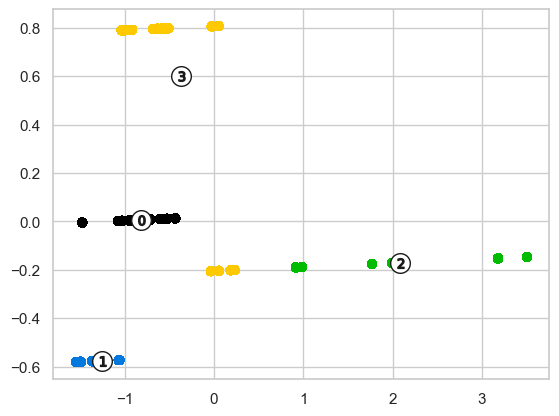

In [22]:
X_pca = pca.fit_transform(X_im)
colors = cm.nipy_spectral(categorie_predict.astype(float) / n_clusters)     
center_clusters_pca = get_center_clusters(n_clusters, categorie_predict, X_pca)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colors)
plt.scatter(center_clusters_pca[:, 0],center_clusters_pca[:, 1],marker="o",c="white",alpha=1,s=200,edgecolor="k")

for i, c in enumerate(center_clusters_pca):
    plt.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

plt.show()

In [23]:
results = imatriculations.copy()
results["categorie_label"] = categorie_predict
vehicules_groups = results.groupby("categorie_label")
clusters_name = [f"Cluster {i}" for i in range(n_clusters)]
index = ["marques","noms","puissances","prix","longueurs","nbPlaces","nbPortes","nbVehicules"]
clusters_data = pd.DataFrame(index=index,columns=clusters_name)
for i, vehicules_group in vehicules_groups:
    col = [] 
    col.append(str(vehicules_group.marque.unique()))
    col.append(str(vehicules_group.nom.unique()))
    col.append(f"{vehicules_group.puissance.min()}-{vehicules_group.puissance.max()}")
    col.append(f"{vehicules_group.prix.min()}-{vehicules_group.prix.max()}")
    col.append(str(vehicules_group.longueur.unique()))
    col.append(vehicules_group.nbPlaces.mode()[0])
    col.append(vehicules_group.nbPortes.mode()[0])
    col.append(vehicules_group.shape[0])
    clusters_data.iloc[:,i] = col 
display(clusters_data)

,Cluster 0,Cluster 1,Cluster 2,Cluster 3
marques,['Volkswagen' 'Renault' 'Mercedes' 'BMW' 'Daci...,['Peugeot' 'Audi' 'Volkswagen' 'Kia' 'Daihatsu...,['Volvo' 'BMW' 'Mercedes' 'Renault'],['Renault' 'Skoda' 'Saab' 'Jaguar' 'Volvo' 'Fo...
noms,['Golf 2.0 FSI' 'Megane 2.0 16V' 'A200' '120i'...,['1007 1.4' 'A2 1.4' 'Polo 1.2 6V' 'Picanto 1....,['S80 T6' 'M5' 'S500' 'Vel Satis 3.5 V6'],['Laguna 2.0T' 'Superb 2.8 V6' '9.3 1.8T' 'X-T...
puissances,90-150,55-115,245-507,102-272
prix,7500-28500,8540-18310,49200-101300,16730-38600
longueurs,['moyenne'],['courte'],['très longue'],['longue' 'très longue']
nbPlaces,5,5,5,5
nbPortes,5,5,5,5
nbVehicules,231278,549666,541076,677980


D'abord, le graphique est conforme au graphique obtenu suite a l'entrainement de modèle de clustering. Ensuite, d'après le tableau les vehicules et caractériques obtenu sont similaires au précédent tableau on peut alors dire que le clustering est généralement correcte.

In [121]:
immatriculations = results.copy()
immatriculations.head()

,immatriculation,marque,nom,puissance,longueur,nbPlaces,nbPortes,couleur,occasion,prix,categorie_label
0,3176 TS 67,Renault,Laguna 2.0T,170,longue,5,5,blanc,False,27300,3
1,3721 QS 49,Volvo,S80 T6,272,très longue,5,5,noir,False,50500,2
2,9099 UV 26,Volkswagen,Golf 2.0 FSI,150,moyenne,5,5,gris,True,16029,0
3,3563 LA 55,Peugeot,1007 1.4,75,courte,5,5,blanc,True,9625,1
4,6963 AX 34,Audi,A2 1.4,75,courte,5,5,gris,False,18310,1


## Entraînement d'un modèle de prédiction de catégorie de véhicule

**Avant d'entrainer le modèle sur les clients il a fallu préparer les données des clients et les corriger. Expliquer les méthodologies, les faire les remarques importantes**

#### 1. Préparation des données des clients

##### 1.1 Chargement des données

In [27]:
clients_51 = pd.read_csv("data/Clients_51.csv", encoding='latin-1')
clients_52 = pd.read_csv("data/Clients_52.csv", encoding='latin-1')
clients_5 = pd.concat([clients_51, clients_52])

In [28]:
clients_5.head()

,age,sexe,taux,situationFamiliale,nbEnfantsAcharge,2eme voiture,immatriculation
0,49,F,914,En Couple,1,false,2170 DJ 60
1,18,M,563,En Couple,4,false,8132 RT 49
2,82,M,417,Célibataire,0,false,4764 CE 84
3,72,M,442,En Couple,4,false,6239 YO 57
4,41,M,592,Célibataire,0,false,9318 FD 10


In [29]:
clients_5.rename(columns={"2eme voiture" : "2emevoiture"}, inplace=True)

In [30]:
clients_data = clients_5.copy()

##### 1.2 Détection des valeurs manquantes

In [31]:
clients_data.isnull().sum()

age                   0
sexe                  0
taux                  0
situationFamiliale    0
nbEnfantsAcharge      0
2emevoiture           0
immatriculation       0
dtype: int64

Il n'y a pas de valeurs manquantes a priori

**Faire les liste des problèmes du jeu de données**. Faire un tableau résumant les problèmes | Méthodologie : Identifié les problèmes et les corriger

In [32]:
clients_data.dtypes

age                   object
sexe                  object
taux                  object
situationFamiliale    object
nbEnfantsAcharge      object
2emevoiture           object
immatriculation       object
dtype: object

* Age est de type object alors qu'il doit être de type numérique
* Taux est de type object alors qu'il doit être de type numérique
* Nombre d'enfant est de type object alors qu'il doit être de type numérique
* 2ème véhicule est de type object alors qu'il doit être de type booléen

Correction des types

In [33]:
clients_data.age = pd.to_numeric(clients_data.age, errors="coerce")
clients_data.taux = pd.to_numeric(clients_data.taux, errors="coerce")
clients_data.nbEnfantsAcharge = pd.to_numeric(clients_data.nbEnfantsAcharge, errors="coerce")

In [34]:
display(clients_data.dtypes)
print("_"*50)
display(clients_data.isnull().sum())
print("_"*50)
clients_data.isin([" ", "?", "N/D", "-1"]).sum()

age                   float64
sexe                   object
taux                  float64
situationFamiliale     object
nbEnfantsAcharge      float64
2emevoiture            object
immatriculation        object
dtype: object

__________________________________________________


age                   388
sexe                    0
taux                  417
situationFamiliale      0
nbEnfantsAcharge      401
2emevoiture             0
immatriculation         0
dtype: int64

__________________________________________________


age                     0
sexe                  586
taux                    0
situationFamiliale    632
nbEnfantsAcharge        0
2emevoiture           386
immatriculation         0
dtype: int64

Il faudra vérifier et corriger chaque colonne

In [35]:
clients_data.replace([" ", "?", "N/D", "-1",-1],np.nan,inplace=True)

**Remplacement des valeurs bizarres par Nan**

In [36]:
clients_data.isnull().sum()

age                   569
sexe                  586
taux                  641
situationFamiliale    632
nbEnfantsAcharge      604
2emevoiture           386
immatriculation         0
dtype: int64

##### 1.3 Nettoyage des données

###### 1.3.1 **Vérification de l'âge**

In [37]:
clients_data.age.unique()

array([49., 18., 82., 72., 41., 54., 30., 56., 73., 31., 34., 70., 39.,
       77., 40., 62., 35., 50., 37., 38., 19., 66., 26., 27., 44., 60.,
       24., 43., 48., 65., 51., 21., 81., 52., 25., 20., 57., 84., 28.,
       23., 45., 47., 53., 22., 42., 80., 59., 58., 32., 71., 33., 74.,
       29., 79., 46., 61., 55., 67., 83., 76., 68., 69., 63., nan, 75.,
       64., 36., 78.])

###### 1.3.2 **Vérification du sexe**

**Domaine de valeur incorrecte**

In [38]:
clients_data.sexe.value_counts()

M           136690
F            58772
Masculin      1378
Homme         1332
Femme          651
Féminin        591
Name: sexe, dtype: int64

In [39]:
clients_data["sexe"] = sexe_vals = clients_data.sexe.map({
    "Masculin":"M",
    "Homme":"M",
    "Femme":"F",
    "Féminin":"F",
    "M":"M",
    "F":"F"
})

In [40]:
clients_data.sexe.value_counts()

M    139400
F     60014
Name: sexe, dtype: int64

###### 1.3.3 **Vérification du taux**

In [41]:
display(clients_data.taux.unique())
display(clients_data.taux.dtypes)

array([ 914.,  563.,  417., ..., 1144., 1170., 1373.])

dtype('float64')

###### 1.3.4 **Vérification du nombre d'enfants**

In [42]:
clients_data.nbEnfantsAcharge.value_counts()

0.0    89928
2.0    33369
1.0    32932
3.0    23125
4.0    20042
Name: nbEnfantsAcharge, dtype: int64

###### 1.2.5 **Vérification 2eme voiture**

**Correction du type**

In [43]:
clients_data["2emevoiture"].value_counts()

false    173756
true      25858
Name: 2emevoiture, dtype: int64

In [44]:
clients_data["2emevoiture"] = clients_data["2emevoiture"].map({
    "true":True,
    "false":False
})

In [45]:
clients_data["2emevoiture"].value_counts()

False    173756
True      25858
Name: 2emevoiture, dtype: int64

###### 1.3.6 **Vérification situation familiale**

**Correction du domaine de valeurs**

In [46]:
clients_data.situationFamiliale.value_counts()

En Couple      128121
Célibataire     59415
Seule            9825
Marié(e)         1317
Seul              588
Divorcée          102
Name: situationFamiliale, dtype: int64

In [47]:
clients_data.situationFamiliale = clients_data.situationFamiliale.map({
    "En Couple": "En Couple", 
    "Célibataire": "Célibataire",
    "Seule" : "Célibataire", 
    "Marié(e)" : "En Couple", 
    "Seul" : "Célibataire",
    "Divorcée": "Célibataire"
})

In [48]:
display(clients_data.situationFamiliale.value_counts())

En Couple      129438
Célibataire     69930
Name: situationFamiliale, dtype: int64

###### **Bilan des valeurs manquantes**

Pourcentage des lignes manquantes.

In [125]:
(clients_data.isnull().sum() / clients_data.shape[0]) * 100

age                   0.2845
sexe                  0.2930
taux                  0.3205
situationFamiliale    0.3160
nbEnfantsAcharge      0.3020
2emevoiture           0.1930
immatriculation       0.0000
dtype: float64

In [126]:
clients_data.shape

(200000, 7)

In [127]:
# Nombre de lignes avec valeurs manquantes
clients_data[clients_data.isna().any(axis=1)].shape

(3396, 7)

In [129]:
(3396/200000) * 100

1.698

In [ ]:
La taux de valeurs manquantes est de 1.698 ce qui presente une finie partie de l'ensemble de données

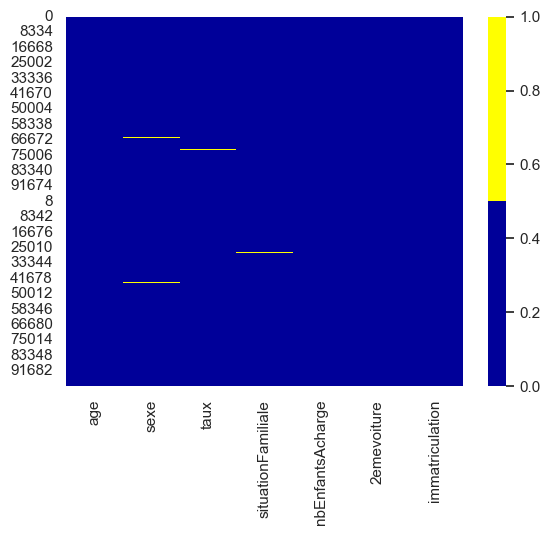

In [52]:
# Heatmap des valeurs manquantes
colours = ['#000099', '#ffff00'] 
sns.heatmap(clients_data.isnull(), cmap=sns.color_palette(colours))
plt.show()

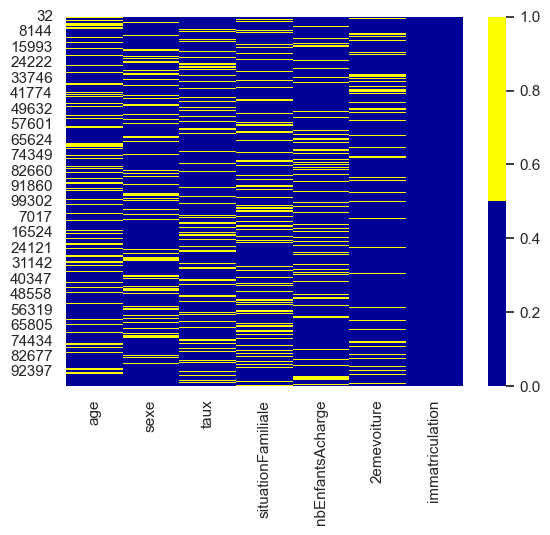

In [53]:
# Heatmap des valeurs manquantes pour les colonnes où une valeurs manques
cols_missing = clients_data[clients_data.isna().any(axis=1)]
colours = ['#000099', '#ffff00'] 
sns.heatmap(cols_missing.isnull(), cmap=sns.color_palette(colours))
plt.show()

Le valeurs manquantes étant peu nombreuses par rapport à l'ensemble de données on peut se permettre de les supprimer. (Préciser que le taux de valeur manquante est trop peu par rapport a l'ensemble de données, on peut se permettre de les supprimer)

In [54]:
clients_data2 = clients_data.dropna()

In [55]:
clients_data2.isnull().sum()

age                   0
sexe                  0
taux                  0
situationFamiliale    0
nbEnfantsAcharge      0
2emevoiture           0
immatriculation       0
dtype: int64

**A partir d'ici les données sont propres on peu passer la suite**

#### 2. Fusion des données clients avec les données d'immatriculations

**Expliquer la méthogologie de fusion des données et de resolution des doublons dans immatriculations**

##### Données d'immatriculations

In [56]:
immatriculations.nunique()

immatriculation    1996632
marque                  19
nom                     28
puissance               22
longueur                 4
nbPlaces                 1
nbPortes                 2
couleur                  5
occasion                 2
prix                    47
categorie_label          4
dtype: int64

In [57]:
print("Doublons d'immatriculations :", immatriculations.immatriculation.duplicated().sum())
print("Lignes en doublon           :", immatriculations.duplicated().sum())
print("Nombre de lignes : ", immatriculations.shape[0])

Doublons d'immatriculations : 3368
Lignes en doublon           : 24
Nombre de lignes :  2000000


Il semble qu'il y est des doublons. On va les supprimer.

In [58]:
immatriculations2 = immatriculations.drop(index=immatriculations[immatriculations.immatriculation.duplicated()].index)
immatriculations2.drop_duplicates(inplace=True)

In [59]:
print("Doublons d'immatriculations :", immatriculations2.immatriculation.duplicated().sum())
print("Lignes en doublon : ", immatriculations2.duplicated().sum())
print("Nombre de lignes : ", immatriculations2.shape[0])

Doublons d'immatriculations : 0
Lignes en doublon :  0
Nombre de lignes :  1996632


In [60]:
# immatriculations2["occasion"] = np.where(immatriculations2["occasion"]==True,1,0)

In [61]:
immatriculations2.head(3)

,immatriculation,marque,nom,puissance,longueur,nbPlaces,nbPortes,couleur,occasion,prix,categorie_label
0,3176 TS 67,Renault,Laguna 2.0T,170,longue,5,5,blanc,False,27300,3
1,3721 QS 49,Volvo,S80 T6,272,très longue,5,5,noir,False,50500,2
2,9099 UV 26,Volkswagen,Golf 2.0 FSI,150,moyenne,5,5,gris,True,16029,0


2.3 Fusion des données

In [62]:
clients_immatriculations = clients_data2.merge(immatriculations2, on="immatriculation")

In [63]:
clients_immatriculations.head(3)

,age,sexe,taux,situationFamiliale,nbEnfantsAcharge,2emevoiture,immatriculation,marque,nom,puissance,longueur,nbPlaces,nbPortes,couleur,occasion,prix,categorie_label
0,49.0,F,914.0,En Couple,1.0,False,2170 DJ 60,Jaguar,X-Type 2.5 V6,197,longue,5,5,gris,False,37100,3
1,18.0,M,563.0,En Couple,4.0,False,8132 RT 49,BMW,M5,507,très longue,5,5,gris,True,66360,2
2,82.0,M,417.0,Célibataire,0.0,False,4764 CE 84,Mercedes,A200,136,moyenne,5,5,gris,True,18130,0


#### 3. Analyse exploratoire

**Mettre les shémas et les interprétations**

##### 3.1 Visualisation

In [64]:
clients_immatriculations2 = clients_immatriculations[["age","sexe","taux","nbEnfantsAcharge","situationFamiliale","2emevoiture","categorie_label"]]

Visualisation de la distribution des variables.

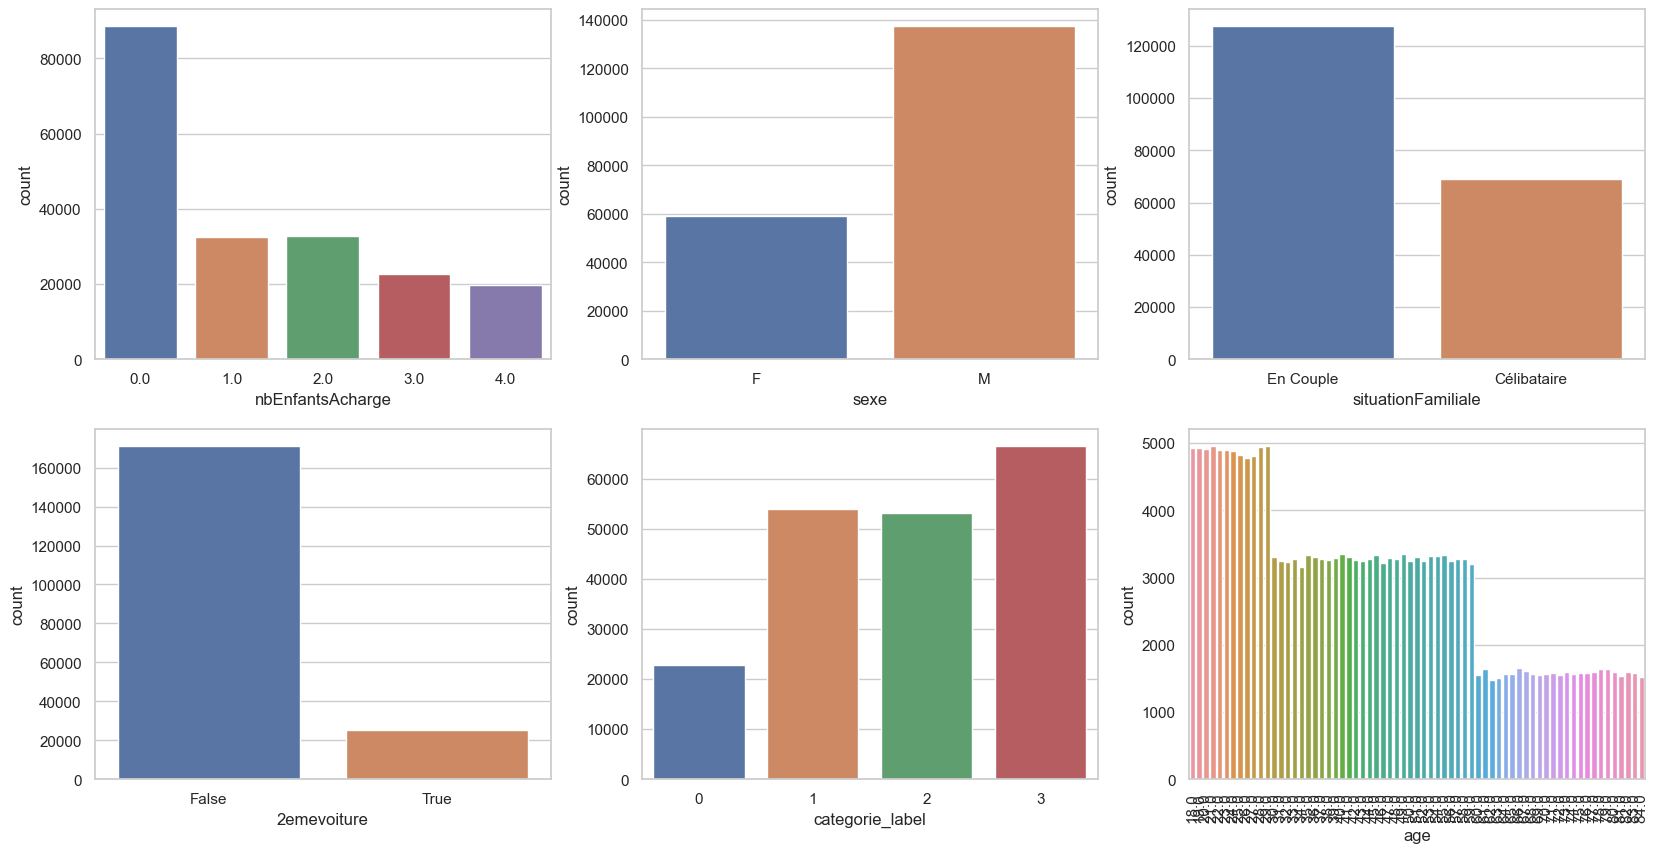

In [65]:
_, axs = plt.subplots(ncols = 3, nrows = 2, figsize=(20, 10))
sns.countplot(data=clients_immatriculations2,x="nbEnfantsAcharge",ax=axs[0,0])
sns.countplot(data=clients_immatriculations2,x="age",ax=axs[1,2])
sns.countplot(data=clients_immatriculations2,x="sexe",ax=axs[0,1])
sns.countplot(data=clients_immatriculations2,x="situationFamiliale",ax=axs[0,2])
sns.countplot(data=clients_immatriculations2,x="2emevoiture",ax=axs[1,0])
sns.countplot(data=clients_immatriculations2,x="categorie_label",ax=axs[1,1])
plt.xticks(rotation=90)
plt.show()

In [66]:
categories_labels = list(categories_map.values())

In [67]:
clients_immatriculations[clients_immatriculations.categorie_label==0][["marque","nom","longueur"]].drop_duplicates()

,marque,nom,longueur
2,Mercedes,A200,moyenne
4,Volkswagen,Golf 2.0 FSI,moyenne
18,Nissan,Almera 1.8,moyenne
41,Dacia,Logan 1.6 MPI,moyenne
61,Audi,A3 2.0 FSI,moyenne
68,Renault,Megane 2.0 16V,moyenne
294,BMW,120i,moyenne
311,Volkswagen,New Beatle 1.8,moyenne


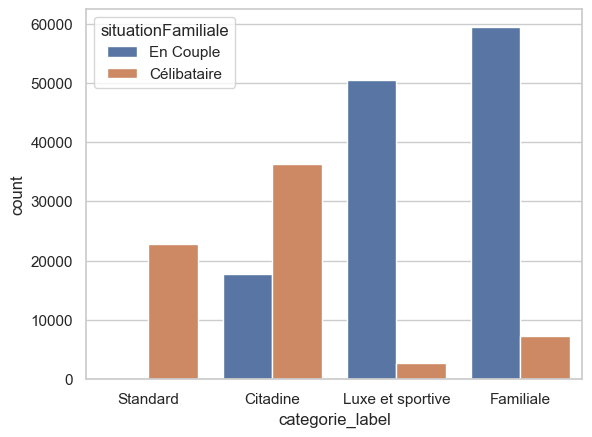

In [68]:
ax = sns.countplot(data=clients_immatriculations2,x="categorie_label",hue="situationFamiliale")
ax.set_xticklabels(labels = categories_labels)
plt.show()

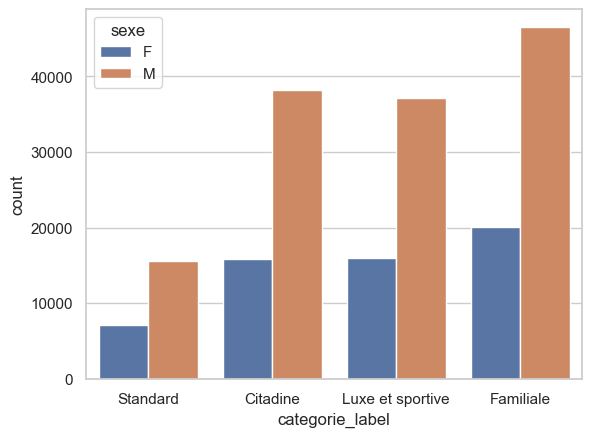

In [69]:
ax = sns.countplot(data=clients_immatriculations2,x="categorie_label",hue="sexe")
ax.set_xticklabels(labels = categories_labels)
plt.show()

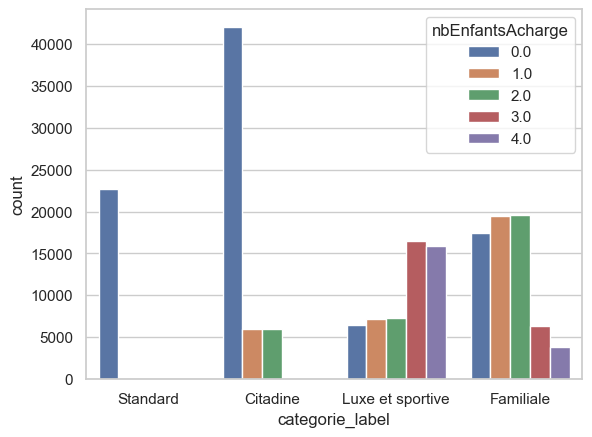

In [70]:
ax = sns.countplot(data=clients_immatriculations2,x="categorie_label",hue="nbEnfantsAcharge")
ax.set_xticklabels(labels = categories_labels)
plt.show()

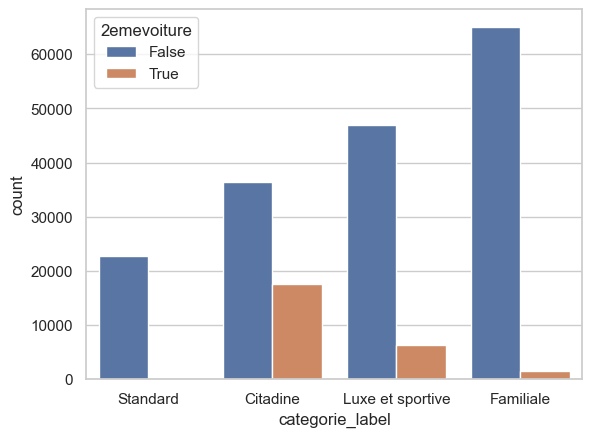

In [71]:
ax = sns.countplot(data=clients_immatriculations2,x="categorie_label",hue="2emevoiture")
ax.set_xticklabels(labels = categories_labels)
plt.show()

**Tirer les conclusions et donner la suite du plan (Entrainement avec ML FLOW + Schema) Préciser l'archicture MLLOW. Important préciser les artifacts obtenu lors de cette étape**

#### Enregistrenement du DataFrame avec Pickle

L'exploration etant terminée on enregistre le DataFrame final avec les label

In [72]:
clients_immatriculations2.head()

,age,sexe,taux,nbEnfantsAcharge,situationFamiliale,2emevoiture,categorie_label
0,49.0,F,914.0,1.0,En Couple,False,3
1,18.0,M,563.0,4.0,En Couple,False,2
2,82.0,M,417.0,0.0,Célibataire,False,0
3,72.0,M,442.0,4.0,En Couple,False,2
4,41.0,M,592.0,0.0,Célibataire,False,0


In [73]:
clients_immatriculations2.dtypes

age                   float64
sexe                   object
taux                  float64
nbEnfantsAcharge      float64
situationFamiliale     object
2emevoiture            object
categorie_label         int32
dtype: object

In [74]:
clients_immatriculations3 = clients_immatriculations2.copy()

In [75]:
clients_immatriculations3["age"] = clients_immatriculations2["age"].astype(np.int64)
clients_immatriculations3["2emevoiture"] = clients_immatriculations2["2emevoiture"].astype(bool)
clients_immatriculations3["nbEnfantsAcharge"] = clients_immatriculations2["nbEnfantsAcharge"].astype(np.int64)
clients_immatriculations3["taux"] = clients_immatriculations2["taux"].astype(np.int64)

In [76]:
clients_immatriculations3.dtypes

age                    int64
sexe                  object
taux                   int64
nbEnfantsAcharge       int64
situationFamiliale    object
2emevoiture             bool
categorie_label        int32
dtype: object

In [77]:
list(clients_immatriculations3.columns)

['age',
 'sexe',
 'taux',
 'nbEnfantsAcharge',
 'situationFamiliale',
 '2emevoiture',
 'categorie_label']

In [78]:
import pickle
import json

In [83]:
# Enregistrement du DataFrame
with open('data/clients_vehicules.pkl', 'wb') as f1:
    pickle.dump(clients_immatriculations3, f1)

# Enregistrement de dictionnaire de mapping des labels
with open('data/clients_vehicules.label_dict.pkl', 'wb') as f1:
    pickle.dump(categories_map, f1)

In [84]:
# Enregistrement de DataFrame au format csv
clients_immatriculations3.to_csv("data/clients_vehicules.csv")

# Enregistrement de mapper au format json
with open('data/clients_vehicules.label_dict.json', 'w') as f1:
    f1.write(json.dumps(categories_map,indent=4))

**Decrire le ML OPS, les métriques et les schméa puis présenter un visuel de l'api avec Docker**

Pour l'entrainement du modèle nous allons utiliser les algorithme suivant :
* Arbre de décision
* RandomForest
* Regression Logisitique

Les métriques utilisée pour l'évaluation du modèle sera l'accuracy en raison de sa simplicité d'interprétation. 

In [81]:
selected_features = ["age","sexe","taux","nbEnfantsAcharge","situationFamiliale","a_2_voitures"]

##### 4.1 Préparation des données

In [82]:
X_train = clients_immatriculations4[selected_features]
y_train = clients_immatriculations4["categorie_label"]

NameError: name 'clients_immatriculations4' is not defined

In [ ]:
X2 = clients_immatriculations4[selected_features]

In [ ]:
categorical_features = ["sexe", "situationFamiliale","a_2_voitures"]
numeric_features = ["taux", "age","nbEnfantsAcharge"]

Création d'une pipeline de transformation des données

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ("onehot", OneHotEncoder(), categorical_features),
        ("scaler", StandardScaler(), numeric_features),
    ]
)

In [ ]:
X_transformed = preprocessor.fit_transform(X_train)

###### 4.2.1 Arbre de décision

In [ ]:
clf_tree = DecisionTreeClassifier()
param_grid_tree = {
    "criterion": ["gini"],
    "max_depth": range(4,8),
    "min_samples_split": range(3,6),
}

In [ ]:
clf_tree_cv = GridSearchCV(clf_tree,param_grid_tree,scoring="accuracy",cv=2,n_jobs=-1)
clf_tree_cv.fit(X_transformed, y_train)

In [ ]:
print(f"Score     :",clf_tree_cv.best_score_)
print(f"Paramètres:",clf_tree_cv.best_params_)

Visualisation de l'arbre

###### 4.2.2 RandomForest

In [ ]:
param_grid_forest = {
    "n_estimators": [150, 200],
    "max_depth": [8,9],
    "min_samples_leaf": [8,9,10]
}

In [ ]:
clf_randomforest = RandomForestClassifier()
clf_randomforest_cv = GridSearchCV(clf_randomforest, param_grid_forest, cv=2, scoring="accuracy",verbose=1)
clf_randomforest_cv.fit(X_transformed, y_train)

In [ ]:
print(f"Score     :",clf_randomforest_cv.best_score_)
print(f"Paramètres:",clf_randomforest_cv.best_params_)

###### 4.2.3 Regression logistique multinomiale


In [ ]:
param_grid = {
      "solver": ["lbfgs","liblinear","newton-cg"], 
      "penalty": ["l2","l1"], 
      "C":[0.5,1.5,2]
}

In [ ]:
clf_logistic = LogisticRegression(multi_class='multinomial')
clf_logistic_cv = GridSearchCV(clf_logistic, param_grid=param_grid, scoring="accuracy", cv=2,n_jobs=-1)
clf_logistic_cv.fit(X_transformed, y_train)

In [ ]:
print(f"Score     :",clf_logistic_cv.best_score_)
print(f"Paramètres:",clf_logistic_cv.best_params_)

Sur la base de l'accuracy, à la virgule prête, on utilise le modèle de RandomForest.

In [ ]:
best_clf_model_name = "RandomForestClassifier"
best_clf_model = clf_randomforest_cv.best_estimator_
best_clf_params = clf_randomforest_cv.best_params_

In [ ]:
print(f"Modèle               : {best_clf_model_name}")
print(f"Meilleur paramétrage : {best_clf_params}")

In [ ]:
vehicule_predict_model = clone(best_clf_model)

### 1. Chargement et préparation des données

In [ ]:
clients = pd.read_csv("/content/drive/Othercomputers/Mon ordinateur portable/DRIVE TIDEV/Projet ecole/TPT/data/Marketing.csv", encoding='latin-1')

In [ ]:
display(clients.shape)
display(clients.describe())
display(clients.dtypes)

In [ ]:
clients.rename(columns={"2emevoiture" : "a_2_voitures"}, inplace=True)

In [ ]:
clients["a_2_voitures"] = np.where(clients.a_2_voitures==True,1,0)

Les données des clients sont propres et prêtes pour la prédiction.

### 2. Prédiction

In [ ]:
X = clients[selected_features]

In [ ]:
X_transformed = preprocessor.fit_transform(X)

In [ ]:
predictions = best_clf_model.predict(X_transformed)

In [ ]:
clients["categorie"] = predictions
clients["categorie"] = clients["categorie"].map(categories_map)

### 3. Résultats

In [ ]:
clients